In [1]:
# ruta clases personalizadas
import sys
ruta_clases = "C:/Users/jgpg000.edu/Desktop/SandBox/clases"
sys.path.append(ruta_clases)

## LIBRERIAS
from pprint import pprint
import pandas as pd
import fitz
from clase_datos import *
from clase_dataset import *
from tqdm import tqdm
import math
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

#### Cargar base de datos

In [2]:
## Cargamos los chunks de texto

# Cargamos excel de proveedores
ruta_excel = "C:/Users/jgpg000.edu/Desktop/Dataset/proveedores/"
ruta_guardar = "C:/Users/jgpg000.edu/Desktop/Dataset/proveedores/base_datos/"
lista_material = pd.read_excel(
    f"{ruta_excel}proveedores_total.xlsx", dtype=str, header=0
    ).to_numpy()
if len(lista_material[lista_material == "nan"]) > 0:
    print("¡Revisa la lista de materiales!")
    raise Exception("Hay valores nulos en la lista de materiales")

# Cargamos documentos
documentos = []
for equipo, proveedor, modelo, pdfs, proyecto in tqdm(lista_material):
    ruta_cargar = f"C:/Users/jgpg000.edu/Desktop/Dataset/proveedores/{proyecto}/"
    if (pdfs == None) or (type(pdfs) is not str): continue
    documento = Documento.cargar(ruta_guardar, ruta_cargar, pdfs)
    documentos.append(documento)
print(len(documentos))

# Convertimos en Langchain
documentos_langchain = []
# Create a document from rows in archivo_textos
for documento in tqdm(documentos):
    #print(documento.nombre_pdf)
    metadata = documento.show()
    #print(metadata)
    documento_langchain = Document(documento.texto_traducido,
                    metadata={
                        key: value for key, value in metadata.items() if key in ['nombre_pdf', 'modelo', 'proveedor', 'equipo']
                        }
                    )
    documentos_langchain.append(documento_langchain)
    if documento.resumenes is None:
        continue
    for resumen_tabla in documento.resumenes:
        resumen_tabla_langchain = Document(resumen_tabla,
                    metadata={
                        key: value for key, value in metadata.items() if key in ['nombre_pdf', 'modelo', 'proveedor', 'equipo']
                        }
                    )
        resumen_tabla_langchain.metadata["tabla"] = True
        documentos_langchain.append(resumen_tabla_langchain)
print(f"Se han cargado {len(documentos)} documentos.")

# Dividimos en chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=30,
    length_function=len,
    is_separator_regex=False,
)

# Dividimos cada texto en chunks
chunks_texto = text_splitter.split_documents(documentos_langchain)
print(f"Hay {len(chunks_texto)} chunks de texto.")

100%|██████████| 59/59 [00:00<00:00, 128.02it/s]


57


100%|██████████| 57/57 [00:00<00:00, 3114.30it/s]


Se han cargado 57 documentos.
Hay 5866 chunks de texto.


#### Modelo RAG

In [3]:
tamano = "large"
model = f"text-embedding-3-{tamano}"
ruta_guardar_vectores = "C:/Users/jgpg000.edu/Desktop/Dataset/proveedores/base_datos_vectores/"
template_sistema: str = """ Eres un asistente de una empresa encargada de smart cities.
Como preguntas, te van a adjuntar listas de requisitos de equipo para proyecto.
Tu labor es responder con el nombre de los equipos que encuentres que cumplan los requisitos, así como suministrar la información de estos dispositivos en relación a los requisitos.
Usa la información añadida en el contexto para responder a la pregunta pero no hagas referencias al mismo.
Se añade como metadato tanto el proveedor como el nombre a los que pertenece el contexto devuelto.
Responde únicamente con la especificación que se pide. Si no aparece di que no lo sabes.
Pregunta: {question}
Metadato: {metadata}
Contexto: {contexts}
La respuesta tiene que tener el siguiente formato:
- Nombre del equipo y proveedor.
- Especificaciones que se han preguntado y aparecen en el contexto.
Respuesta:
"""

modelo="gpt-4o"
vectorstore = crear_database(f"{ruta_guardar_vectores}{tamano}_esp", chunks_texto, nombre_embedding = model)
print(f"El espacio tiene {vectorstore.index.ntotal} vectores.")
retriever = crear_retriever(vectorstore)
rag = crear_RAG(retriever=retriever,
                plantilla_RAG=template_sistema,
                model=modelo)
#rag ## clear clase para mostrar las propiedades de cada rag

El espacio tiene 5866 vectores.


#### Nueva etapa: dividimos las preguntas en sentencias y buscamos modelos que cumplan cada especificación

In [4]:
ruta_excel = "C:/Users/jgpg000.edu/Desktop/Dataset/QA_Dataset.xlsx"
qa = QADataset(ruta_excel)
qa.show()[:3]

,question,answer,contexts,ground_truth
0,Las especificaciones mínimas de las cámaras se...,nan,nan,NL GHOST AI procesa analíticas de vídeo aplica...
1,Las especificaciones mínimas de las cámaras PT...,nan,nan,Cámara 2.0C-H4IRPTZ-DP30-WP del fabricante Avi...
2,Los sonómetros deberán satisfacer las siguient...,nan,nan,Sonómetro B&K 2245 Sound Level Meter de HBK. \...


In [5]:
search_kwargs={"k": 8, "fetch_k": 40, "filter": {"equipo": "camara"}}
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs=search_kwargs)
rag = crear_RAG(retriever=retriever,
                plantilla_RAG=template_sistema,
                model=modelo)

In [47]:
q0 = qa.question[0]
sentencias = q0.split("[LISTA]")
sentencias[:3]

lista_null = ['nan' for i in range(len(sentencias))]
contexts_proveedor, contexts_equipo, contexts_modelo = lista_null.copy(), lista_null.copy(), lista_null.copy()
for i, sentencia in enumerate(sentencias):
    solution = retriever.invoke(sentencia)
    contexts_proveedor[i] = [context.metadata["proveedor"] for context in solution]
    contexts_equipo[i] = [context.metadata["equipo"] for context in solution]
    contexts_modelo[i] = [context.metadata["modelo"] for context in solution]


In [33]:
contexts_equipo

[['camara',
  'camara',
  'camara',
  'camara',
  'camara',
  'camara',
  'camara',
  'camara'],
 ['camara',
  'camara',
  'camara',
  'camara',
  'camara',
  'camara',
  'camara',
  'cinemometro sancionador'],
 ['camara',
  'camara',
  'camara',
  'camara',
  'camara',
  'camara',
  'camara',
  'cinemometro sancionador'],
 ['camara',
  'cinemometro sancionador',
  'camara',
  'camara',
  'camara',
  'camara',
  'camara',
  'servidor vms'],
 ['camara',
  'servidor vms',
  'camara',
  'camara',
  'cinemometro sancionador',
  'camara',
  'cinemometro sancionador',
  'camara'],
 ['camara',
  'licencia',
  'camara',
  'camara',
  'camara',
  'servidor vms',
  'escaner',
  'servidor vms'],
 ['smart parking node',
  'sonometro',
  'smart parking node',
  'switch',
  'camara',
  'camara',
  'smart parking node',
  'smart parking node'],
 ['cinemometro sancionador',
  'paso de peatones',
  'camara',
  'camara',
  'licencia',
  'camara',
  'camara',
  'smart parking node'],
 ['servidor vms',
  

Usando una moda local de proveedores y productos

#### Generamos respuestas del dataset: MODA LOCAL

In [ ]:
import collections
lista_materiales = set(lista_material[:,0])
final_modelo, final_proveedor, final_equipo = [], [], []

# MODA local
for j in range(len(qa)):
    # Filtramos para cada equipo
    equipo = qa.equipo[j]
    # Nos quedamos con un k pequeño -> nos interesa el modelo y no el chunk de especificaciones
    search_kwargs={"k": 1, "fetch_k": 30}
    if equipo in lista_materiales: # buscamos si existe ese equipo
        search_kwargs["filter"] = {"equipo": equipo}
    
    # Del retriever solo buscamos el modelo del chunk
    retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs=search_kwargs)

    # Dividimos la pregunta en sentencias
    question = qa.question[j]
    sentencias = question.split("[LISTA]")[1:] # eliminamos la introdución
    print(f"La pregunta {j} tiene {len(sentencias)} sentencias.")
    num_sentencias, temp_modelo, temp_proveedor, temp_equipo = [], [], [], []

    for i, sentencia in enumerate(sentencias):
        retrievals = retriever.invoke(sentencia)
        if retrievals == []: continue
        
        # Elegimos el mejor modelo sugún cada sentencia
        contexts_modelo = [context.metadata["modelo"] for context in retrievals]
        temp_modelo.append(collections.Counter(contexts_modelo).most_common(1)[0][0])
        # Idem para proveedor
        contexts_proveedor = [context.metadata["proveedor"] for context in retrievals]
        temp_proveedor.append(collections.Counter(contexts_proveedor).most_common(1)[0][0])
        # Idem para equipo
        contexts_equipo = [context.metadata["equipo"] for context in retrievals]
        temp_equipo.append(collections.Counter(contexts_equipo).most_common(1)[0][0])


    # El final es la moda de las sentencias
    num_sentencias.append(i+1)
    final_modelo.append(collections.Counter(temp_modelo).most_common(1))
    final_proveedor.append(collections.Counter(temp_proveedor).most_common(1))
    final_equipo.append(collections.Counter(temp_equipo).most_common(1))
    print(f"Pregunta {j}: {final_modelo[j]} de {final_proveedor[j]} de {final_equipo[j]}")


La pregunta 0 tiene 23 sentencias.
Pregunta 0: [('DS-TCG406-E', 6)] de [('Bosch', 10)] de [('camara', 23)]
La pregunta 1 tiene 26 sentencias.
Pregunta 1: [('DINION 5100i IR', 4)] de [('Bosch', 20)] de [('camara', 26)]
La pregunta 2 tiene 3 sentencias.
Pregunta 2: [('B&K 2245', 2)] de [('HBK', 2)] de [('sonometro', 3)]
La pregunta 3 tiene 20 sentencias.
Pregunta 3: [('Cabina Smart Spot, Smart Parking Node', 17)] de [('Libelium', 17)] de [('smart parking node', 17)]
La pregunta 4 tiene 6 sentencias.
Pregunta 4: [('Paso de peatones inteligente', 6)] de [('Interlight', 6)] de [('paso de peatones', 6)]
La pregunta 5 tiene 14 sentencias.
Pregunta 5: [('Evolis', 10)] de [('Elancity', 10)] de [('radar pedagogico', 10)]
La pregunta 6 tiene 27 sentencias.
Pregunta 6: [('55" 55BDL2005X/00', 21)] de [('Philips', 21)] de [('monitor', 21)]
La pregunta 7 tiene 11 sentencias.
Pregunta 7: [('RM7-WKS-2MN-EU', 9)] de [('Avigilon', 9)] de [('workstation', 9)]
La pregunta 8 tiene 21 sentencias.
Pregunta 8:

In [55]:
## GENERAR RESPUESTAS ## A cada pregunta le asignamos el modelo más común
model = "gpt-4o"

lista_modelos = set(lista_material[:,2])
for i in range(len(qa)):
    modelo = final_modelo[i][0][0]
    num_sentencia = num_sentencias[i]
    search_kwargs={"k": num_sentencia, "fetch_k": 3*num_sentencia}
    if modelo in lista_modelos: # buscamos si existe ese equipo
        search_kwargs["filter"] = {"modelo": modelo}
    else:
        print("No hay filtro del modelo")
        search_kwargs["filter"] = {}

    retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs=search_kwargs)
    rag = crear_RAG(retriever=retriever,
                    plantilla_RAG=template_sistema,
                    model=model)
    qa.generar_respuesta_individual(rag, num_pregunta_dataset=i)
    print(f"La pregunta {i} ha sido respondida.")
qa.show()[:4]

{'contexts': [Document(page_content='Parking Entrance & Exit. La cámara utiliza JPEG para el formato de imagen y tiene una resolución de captura de 2688 × 1520. Puede reconocer placas en direcciones Forward, Backward, y Bidirection, y cuenta con un filtro de placas falsas. El control de LED soporta control automático o por tiempo. La', metadata={'nombre_pdf': 'hikvision-DS-TCG406-E_Datasheet_20230704', 'modelo': 'DS-TCG406-E', 'proveedor': 'HikVision', 'equipo': 'camara', 'tabla': True}), Document(page_content='LPR Tasa de captura > 98 % Precisión de reconocimiento de dirección de movimiento del vehículo > 98,5 % Precisión LPR > 98 % Tasa de captura errónea < 2 % Regiones europeas y de habla rusa: Precisión LPR > 98 % Precisión de reconocimiento de país/región > 95 % Reconocimiento de tipo de vehículo', metadata={'nombre_pdf': 'hikvision-DS-TCG406-E_Datasheet_20230704', 'modelo': 'DS-TCG406-E', 'proveedor': 'HikVision', 'equipo': 'camara'}), Document(page_content='+ A11); CE-LVD (EN 62

,question,answer,contexts,ground_truth
0,Las especificaciones mínimas de las cámaras se...,- Nombre del equipo y proveedor: HikVision DS-...,[Parking Entrance & Exit. La cámara utiliza JP...,NL GHOST AI procesa analíticas de vídeo aplica...
1,Las especificaciones mínimas de las cámaras PT...,- Nombre del equipo y proveedor: Bosch DINION ...,[de cámara/lente puede cumplir estos criterios...,Cámara 2.0C-H4IRPTZ-DP30-WP del fabricante Avi...
2,Los sonómetros deberán satisfacer las siguient...,"- Nombre del equipo y proveedor: B&K 2245, HBK...",[[TABLA] El modelo de sonómetro B&K 2245 del p...,Sonómetro B&K 2245 Sound Level Meter de HBK. \...
3,Las especificaciones mínimas de los sensores s...,- Nombre del equipo y proveedor: Smart Parking...,[en la sección “Proceso de inicio del imán”. F...,Sensor Smart Parking Node de Libelium. Princip...


In [56]:
## GUARDAMOS EL DATASET CON LAS RESPUESTAS GENERADAS POR EL MODELO
## formato nombre: QA-modelo-Q#: QA-(modeloRAG)-(num. preg. dataset)
ruta_guardar = "C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/"
nombre_archivo = "QA-moda_producto_local-Q16"

qa.guardar(ruta_guardar, nombre_archivo) # guarda en csv

Se ha guardado el dataset en C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/QA-moda_producto_local-Q16.csv


In [57]:
ruta_guardar = "C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/"
nombre_archivo = "QA-moda_producto_local-Q16"
## Comprobar que se ha guardado correctamente (cargando el modelo)
qa = QADataset(f"{ruta_guardar}{nombre_archivo}.csv")
qa.show()[:4]
qa.show_metrics()[:3]

,answer_relevancy,context_relevancy,context_recall,answer_similarity,answer_correctness,precision_bertscore,recall_bertscore,f1_bertscore,mismo_producto,especificaciones_correctas,especificaciones_correctas_norm
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Evaluamos la calidad de las respuestas generadas

In [ ]:
##### LISTA METRICAS #####
# ['answer_relevancy', 'context_relevancy', 'context_recall', 'answer_similarity',
# 'answer_correctness', 'precision_bertscore', 'recall_bertscore', 'f1_bertscore',
# 'mismo_producto', 'especificaciones_correctas', 'especificaciones_correctas_norm']

In [59]:
from ragas.metrics import context_relevancy, answer_similarity, answer_correctness
metricas = [context_relevancy, answer_similarity, answer_correctness]

# generamos todas las métricas con el siguiente bucle
result_ragas = qa.ragas(metricas= metricas)
qa.bertscore()
qa.es_mismo_producto(modelo_llm="gpt-4o")
qa.son_especificaciones_correctas(modelo_llm="gpt-3.5")

# Guardamos el dataset con métricas
ruta_guardar = "C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/"
nombre_archivo = "QA-moda_producto_local-Q16"
qa.guardar(ruta_guardar, nombre_archivo, sobreescribir=True)

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

BERTScore Precision: 0.7140, Recall: 0.6811, F1: 0.6954
El archivo ya existe.
Se ha guardado el dataset en C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/QA-moda_producto_local-Q16.csv


In [91]:
# Incluimos la métrica del número de especificaciones correctas normalizadas
ruta_excel = "C:/Users/jgpg000.edu/Desktop/Dataset/QA_Dataset.xlsx"
dataset = pd.read_excel(ruta_excel, sheet_name="QA2", dtype=str, header=0)
num_especificaciones = dataset['nº ENCONTRADAS EN DATASHEET'].dropna().astype(int).reset_index(drop=True)

qa.son_especificaciones_correctas_norm(num_especificaciones)
qa.guardar(ruta_guardar, nombre_archivo, sobreescribir=True)
qa.especificaciones_correctas_norm[:3]

Se ha guardado el dataset en C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/QA-moda_producto_local-Q16.csv


[0.375, 0.68, 0.2222222222222222]

#### Gráfico de métricas
Además del gráfico se ve bien en wandb

La QA correcta 14 tiene tantas especificaciones_correctas sin acertar el producto porque la mayoría de la ground_truth es "no lo sé".

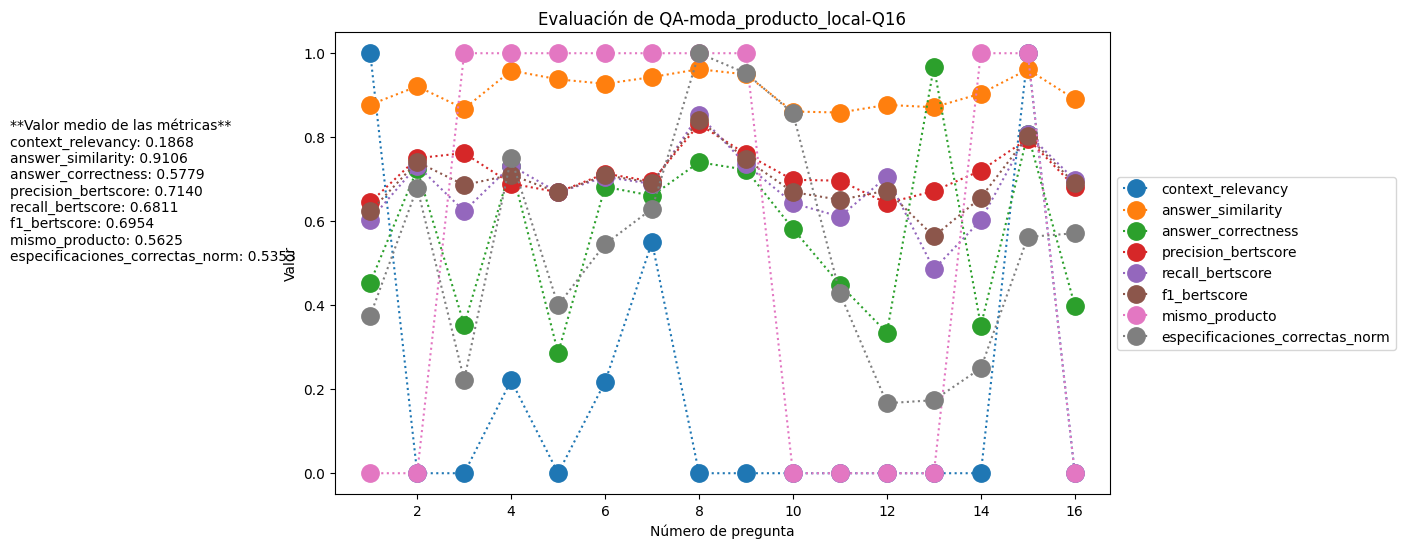

In [92]:
metricas = QADataset.columnas_metricas.copy()
metricas.remove("especificaciones_correctas")
metricas.remove("answer_relevancy")
metricas.remove("context_recall")

ruta_graficos = "C:/Users/jgpg000.edu/Desktop/Graficos/"
nombre_archivo = "QA-moda_producto_local-Q16"
qa.grafico(nombre_archivo, ruta_graficos, metricas = metricas)

In [86]:
qa.especificaciones_correctas

[6, 17, 4, 12, 4, 6, 17, 12, 20, 12, 6, 1, 5, 0, 6, 1]

In [4]:
#fila excel
i = 16
#modificar metrica a mano
qa.mismo_producto[i-2] = 1

Se ha guardado el dataset en C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/QA-baseline_esp_large-Q16.csv


In [90]:
#fila excel
i = 17
#modificar metrica a mano
qa.especificaciones_correctas[i-2] = 4

## Generamos respuestas usando una moda global

Usando una moda global de proveedores y productos

In [93]:
import collections
lista_materiales = set(lista_material[:,0])
lista_null = ['nan' for i in range(len(qa))]
proveedor_elegido, producto_elegido = lista_null.copy(), lista_null.copy()


### MODA GLOBAL DE PROVEEDORES Y PRODUCTOS
for j in range(len(qa)):
    # Filtramos para cada equipo
    equipo = qa.equipo[j]
    # Nos quedamos con un k pequeño -> nos interesa el modelo y no el chunk de especificaciones
    search_kwargs={"k": 3, "fetch_k": 50}
    if equipo in lista_materiales: # buscamos si existe ese equipo
        search_kwargs["filter"] = {"equipo": equipo}

    retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs=search_kwargs)


    # Dividimos la pregunta en sentencias
    question = qa.question[j]
    sentencias = question.split("[LISTA]")[1:]

    print(f"La pregunta {j} tiene {len(sentencias)} sentencias.")
    lista_null = ['nan' for i in range(len(sentencias))]
    contexts_proveedor, contexts_equipo, contexts_modelo = lista_null.copy(), lista_null.copy(), lista_null.copy()

    lista_proveedor, lista_equipo, lista_modelo = [], [], []
    for i, sentencia in enumerate(sentencias):
        solution = retriever.invoke(sentencia)

        contexts_proveedor[i] = [context.metadata["proveedor"] for context in solution]
        contexts_equipo[i] = [context.metadata["equipo"] for context in solution]
        contexts_modelo[i] = [context.metadata["modelo"] for context in solution]
        lista_proveedor.extend(contexts_proveedor[i])
        lista_equipo.extend(contexts_equipo[i])
        lista_modelo.extend(contexts_modelo[i])


    producto_elegido[j] = collections.Counter(lista_modelo).most_common(3)
    proveedor_elegido[j] = collections.Counter(lista_proveedor).most_common(3)

    print(collections.Counter(lista_proveedor))
    print(collections.Counter(lista_equipo))
    print(collections.Counter(lista_modelo))
print(producto_elegido)
print(proveedor_elegido)

La pregunta 0 tiene 23 sentencias.
Counter({'Bosch': 38, 'Avigilon': 12, 'HikVision': 11, 'Neural Labs': 8})
Counter({'camara': 69})
Counter({'DS-TCG406-E': 11, 'NL Ghost AI': 7, 'NBE-6502-AL Bullet DINION IP starlight 6000i IR': 6, 'DINION 5100i IR': 5, 'NDV-8502-RX Domo fijo FLEXIDOME IP indoor 8000i': 5, 'FLEXIDOME IP starlight 8000i - 8MP': 5, 'FLEXIDOME outdoor 5100i IR (NDE-5703-AL)': 4, 'FLEXIDOME outdoor 3100i IR': 4, 'H5A Doble Cabezal': 3, 'DINION 7100i IR': 3, 'H5A PTZ Resistente': 3, 'FLEXIDOME corner 7100i IR': 3, 'H5A Cámara Térmica': 2, '2.0C-H4IRPTZ-DP30-WP': 2, 'NDV-8504-R Domo fijo FLEXIDOME IP indoor 8000i': 2, 'H5A FISHEYE': 1, 'H5 PRO': 1, 'FLEXIDOME IP 3000i IR': 1, 'NL Ghost OV': 1})
La pregunta 1 tiene 26 sentencias.
Counter({'Bosch': 51, 'Avigilon': 20, 'HikVision': 5, 'Neural Labs': 2})
Counter({'camara': 78})
Counter({'DINION 5100i IR': 8, 'H5A Doble Cabezal': 7, 'FLEXIDOME IP 3000i IR': 6, 'FLEXIDOME IP starlight 8000i - 8MP': 6, 'DS-TCG406-E': 5, 'NBE-6502-

In [100]:
for i in range(len(qa)):
    print(num_sentencias[i],": ", producto_elegido[i][0][0])

24 :  DS-TCG406-E
27 :  DINION 5100i IR
4 :  B&K 2245
21 :  Cabina Smart Spot, Smart Parking Node
7 :  Paso de peatones inteligente
15 :  Evolis
28 :  55" 55BDL2005X/00
12 :  RM7-WKS-2MN-EU
22 :  100F
22 :  DINION 5100i IR
22 :  DINION 5100i IR
7 :  6360
16 :  FLEXIDOME outdoor 3100i IR
11 :  QX-33-TC-RAD
7 :  B&K 2245
9 :  Sentinel Rack


In [99]:
ruta_excel = "C:/Users/jgpg000.edu/Desktop/Dataset/QA_Dataset.xlsx"
qa = QADataset(ruta_excel)
qa.show()[:3]

,question,answer,contexts,ground_truth
0,Las especificaciones mínimas de las cámaras se...,nan,nan,NL GHOST AI procesa analíticas de vídeo aplica...
1,Las especificaciones mínimas de las cámaras PT...,nan,nan,Cámara 2.0C-H4IRPTZ-DP30-WP del fabricante Avi...
2,Los sonómetros deberán satisfacer las siguient...,nan,nan,Sonómetro B&K 2245 Sound Level Meter de HBK. \...


In [101]:
## GENERAR RESPUESTAS ## A cada pregunta le asignamos el modelo más común
model = "gpt-4o"

lista_modelos = set(lista_material[:,2])
for i in range(len(qa)):
    modelo = producto_elegido[i][0][0]
    num_sentencia = num_sentencias[i]
    search_kwargs={"k": num_sentencia, "fetch_k": 3*num_sentencia}
    if modelo in lista_modelos: # buscamos si existe ese equipo
        search_kwargs["filter"] = {"modelo": modelo}
    else:
        print("No hay filtro del modelo")
        search_kwargs["filter"] = {}

    retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs=search_kwargs)
    rag = crear_RAG(retriever=retriever,
                    plantilla_RAG=template_sistema,
                    model=model)
    qa.generar_respuesta_individual(rag, num_pregunta_dataset=i)
    print(f"La pregunta {i} ha sido respondida.")
qa.show()[:4]

{'contexts': [Document(page_content='Parking Entrance & Exit. La cámara utiliza JPEG para el formato de imagen y tiene una resolución de captura de 2688 × 1520. Puede reconocer placas en direcciones Forward, Backward, y Bidirection, y cuenta con un filtro de placas falsas. El control de LED soporta control automático o por tiempo. La', metadata={'nombre_pdf': 'hikvision-DS-TCG406-E_Datasheet_20230704', 'modelo': 'DS-TCG406-E', 'proveedor': 'HikVision', 'equipo': 'camara', 'tabla': True}), Document(page_content='LPR Tasa de captura > 98 % Precisión de reconocimiento de dirección de movimiento del vehículo > 98,5 % Precisión LPR > 98 % Tasa de captura errónea < 2 % Regiones europeas y de habla rusa: Precisión LPR > 98 % Precisión de reconocimiento de país/región > 95 % Reconocimiento de tipo de vehículo', metadata={'nombre_pdf': 'hikvision-DS-TCG406-E_Datasheet_20230704', 'modelo': 'DS-TCG406-E', 'proveedor': 'HikVision', 'equipo': 'camara'}), Document(page_content='+ A11); CE-LVD (EN 62

,question,answer,contexts,ground_truth
0,Las especificaciones mínimas de las cámaras se...,- Nombre del equipo y proveedor: HikVision DS-...,[Parking Entrance & Exit. La cámara utiliza JP...,NL GHOST AI procesa analíticas de vídeo aplica...
1,Las especificaciones mínimas de las cámaras PT...,- Nombre del equipo y proveedor: Bosch DINION ...,[de cámara/lente puede cumplir estos criterios...,Cámara 2.0C-H4IRPTZ-DP30-WP del fabricante Avi...
2,Los sonómetros deberán satisfacer las siguient...,"- Nombre del equipo y proveedor: B&K 2245, HBK...",[[TABLA] El modelo de sonómetro B&K 2245 del p...,Sonómetro B&K 2245 Sound Level Meter de HBK. \...
3,Las especificaciones mínimas de los sensores s...,- Nombre del equipo y proveedor: Smart Parking...,[en la sección “Proceso de inicio del imán”. F...,Sensor Smart Parking Node de Libelium. Princip...


In [102]:
## GUARDAMOS EL DATASET CON LAS RESPUESTAS GENERADAS POR EL MODELO
## formato nombre: QA-modelo-Q#: QA-(modeloRAG)-(num. preg. dataset)
ruta_guardar = "C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/"
nombre_archivo = "QA-moda_producto_global-Q16"

qa.guardar(ruta_guardar, nombre_archivo) # guarda en csv

Se ha guardado el dataset en C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/QA-moda_producto_global-Q16.csv


In [103]:
ruta_guardar = "C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/"
nombre_archivo = "QA-moda_producto_global-Q16"
## Comprobar que se ha guardado correctamente (cargando el modelo)
qa = QADataset(f"{ruta_guardar}{nombre_archivo}.csv")
qa.show()[:4]
qa.show_metrics()[:3]

,answer_relevancy,context_relevancy,context_recall,answer_similarity,answer_correctness,precision_bertscore,recall_bertscore,f1_bertscore,mismo_producto,especificaciones_correctas,especificaciones_correctas_norm
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Evaluamos la calidad de las respuestas generadas

In [ ]:
##### LISTA METRICAS #####
# ['answer_relevancy', 'context_relevancy', 'context_recall', 'answer_similarity',
# 'answer_correctness', 'precision_bertscore', 'recall_bertscore', 'f1_bertscore',
# 'mismo_producto', 'especificaciones_correctas', 'especificaciones_correctas_norm']

In [105]:
from ragas.metrics import context_relevancy, answer_similarity, answer_correctness
metricas = [context_relevancy, answer_similarity, answer_correctness]

# generamos todas las métricas con el siguiente bucle
result_ragas = qa.ragas(metricas= metricas)
qa.bertscore()
qa.es_mismo_producto(modelo_llm="gpt-4o")
qa.son_especificaciones_correctas(modelo_llm="gpt-3.5-turbo")

# Guardamos el dataset con métricas
ruta_guardar = "C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/"
nombre_archivo = "QA-moda_producto_global-Q16"
qa.guardar(ruta_guardar, nombre_archivo, sobreescribir=True)

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

BERTScore Precision: 0.7068, Recall: 0.6740, F1: 0.6883
Se ha guardado el dataset en C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/QA-moda_producto_global-Q16.csv


In [142]:
# Incluimos la métrica del número de especificaciones correctas normalizadas
ruta_excel = "C:/Users/jgpg000.edu/Desktop/Dataset/QA_Dataset.xlsx"
dataset = pd.read_excel(ruta_excel, sheet_name="QA2", dtype=str, header=0)
num_especificaciones = dataset['nº ENCONTRADAS EN DATASHEET'].dropna().astype(int).reset_index(drop=True)

qa.son_especificaciones_correctas_norm(num_especificaciones)
qa.guardar(ruta_guardar, nombre_archivo, sobreescribir=True)
qa.especificaciones_correctas_norm[:3]

Se ha guardado el dataset en C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/QA-moda_producto_global-Q16.csv


[0.375, 0.36, 0.2777777777777778]

#### Gráfico de métricas
Además del gráfico se ve bien en wandb

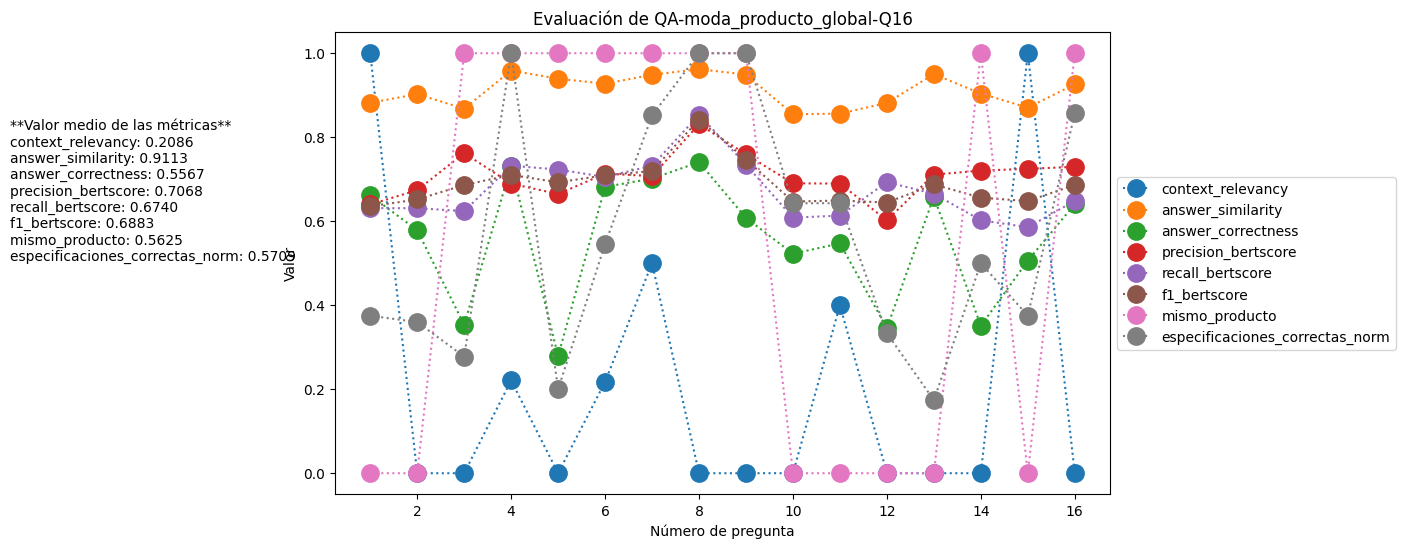

In [141]:
metricas = QADataset.columnas_metricas.copy()
metricas.remove("especificaciones_correctas")
metricas.remove("answer_relevancy")
metricas.remove("context_recall")

ruta_graficos = "C:/Users/jgpg000.edu/Desktop/Graficos/"
nombre_archivo = "QA-moda_producto_global-Q16"
qa.grafico(nombre_archivo, ruta_graficos, metricas = metricas)

In [133]:
qa.especificaciones_correctas

[6, 9, 5, 20, 2, 6, 23, 12, 21, 9, 9, 4, 22, 2, 6, 9]

In [140]:
#fila excel
i = 17
#modificar metrica a mano
qa.mismo_producto[i-2] = 1

In [139]:
#fila excel
i = 17
#modificar metrica a mano
qa.especificaciones_correctas[i-2] = 6

#### Tracing con wandb

In [16]:
import wandb
from wandb.sdk.data_types.trace_tree import Trace

# cargamos datos
status = "success"
status_message = (None,)
dataset_questions = qa.show()
dataset_metrics = qa.show_metrics()
i=0
nombre_archivo = "QA-baseline_esp_large-Q16"
dataset = pd.concat([dataset_questions, dataset_metrics], axis=1)
# start a wandb run to log to
wandb.init(project="trace-ragas", name=nombre_archivo)
for i in range(len(dataset)):
        fila = dataset.loc[i]
        # create a span in wandb
        root_span = Trace(
            name=f"Q{i}",
            kind="chain",  # kind can be "llm", "chain", "agent" or "tool"
            status_code=status,
            status_message=status_message,
            inputs = {
                    col: fila[col] for col in QADataset.columnas_dataset if col in fila  
                    },
            outputs = {
                    col: fila[col] for col in QADataset.columnas_metricas if col in fila
                    }
        )
        # log the span to wandb
        root_span.log(name="rag_trace")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jgpg000-edu (jgpginnovasur). Use `wandb login --relogin` to force relogin
